## Importing Data & Packages

In [1]:
import numpy  as np
import pandas as pd
import geopandas as gpd
import json

import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

from sklearn import cluster

import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud

import folium
from branca.element import Figure
from sklearn.cluster import KMeans
from training_data import get_raw_data_notebook

In [2]:
import nest_asyncio
import twint
import pandas as pd

nest_asyncio.apply()

%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../green_mood_tracker/')
from twint_class import TWINT

In [3]:
kwargs = dict(
    keywords=['nuclear'],
    cities=['London', 'Paris'],
    since = '2020-11-08 12:00:00',
    store_csv=False,
    limit=500
)

t = TWINT(**kwargs)

df_city = t.city_df()

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.


## Preprocessing

In [4]:
from data_cleaning import clean

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/thomasgiannetti/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
df = clean(df_city, 'tweet')

In [6]:
df['tweet'] = df['tweet'].str.replace(kwargs['keywords'][0], '')

In [7]:
df.head()

,cashtags,conversation_id,created_at,date,day,geo,hashtags,hour,id,language,...,trans_src,translate,tweet,urls,user_id,user_id_str,user_rt,user_rt_id,username,video
0,[],1331664732894474240,1.606329e+12,2020-11-25 18:23:08,3,,"[karabakhisazerbaijan, dontbelievearmenia]",18,1331664732894474240,en,...,,,stepan danielyan chairman center partnership d...,[],1285880933988675585,1285880933988675585,,,ElyaMK1,0
1,[],1331644466445361156,1.606328e+12,2020-11-25 18:20:59,3,,[],18,1331664195134349323,en,...,,,waste million country space program weapon,[],337062836,337062836,,,paulmward66,0
2,[],1331649415476604928,1.606328e+12,2020-11-25 18:15:24,3,,[],18,1331662788855554048,en,...,,,conservative strong believer family progressi...,[],1145733731493339137,1145733731493339137,,,BritishConserv3,0
3,[],1331644466445361156,1.606328e+12,2020-11-25 18:14:36,3,,[],18,1331662588812423168,en,...,,,foreign aid mostly bribery especially given af...,[],1274964821902049280,1274964821902049280,,,MarcFre33138654,0
4,[],1331662471589990402,1.606328e+12,2020-11-25 18:14:08,3,,[],18,1331662471589990402,en,...,,,national infrastructure strategy government te...,[],165950389,165950389,,,mattrooney11,1


In [27]:
df.columns

Index(['cashtags', 'conversation_id', 'created_at', 'date', 'day', 'geo',
       'hashtags', 'hour', 'id', 'language', 'link', 'name', 'near', 'nlikes',
       'nreplies', 'nretweets', 'photos', 'place', 'quote_url', 'reply_to',
       'retweet', 'retweet_date', 'retweet_id', 'search', 'source',
       'thumbnail', 'timezone', 'trans_dest', 'trans_src', 'translate',
       'tweet', 'urls', 'user_id', 'user_id_str', 'user_rt', 'user_rt_id',
       'username', 'video'],
      dtype='object')

### Data Vectorizing

In [8]:
corpus = df['tweet'].tolist()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

721 rows


,0,1,2,3,4,5,6,7,8,9,...,711,712,713,714,715,716,717,718,719,720
burn,0.225194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
center,0.225194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chairman,0.225194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
danielyan,0.225194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dontbelievearmenia,0.225194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## KMeans - Finding Optimal Number of Clusters - Elbow Method

### Code

In [12]:
Nc = range(1, 70)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score

[-711.0341861802037,
 -704.317206021696,
 -700.9471182239179,
 -698.2869815204403,
 -696.3654695303236,
 -693.5580592628206,
 -691.7525399024387,
 -688.6545067789756,
 -687.551050270154,
 -686.6464812976334,
 -683.7133082906114,
 -682.796193081317,
 -678.9147076488902,
 -678.7520359785088,
 -677.0225376576925,
 -675.1344187371827,
 -674.721138154938,
 -671.8622599387675,
 -672.2668142503122,
 -667.5483979757306,
 -666.644071389509,
 -664.6546092120442,
 -661.6778592837094,
 -662.2194087681801,
 -660.234445384773,
 -661.2667373674873,
 -656.8876722664327,
 -654.6154504824465,
 -651.7114918202374,
 -651.0242910160206,
 -650.53678358326,
 -648.8894946751599,
 -647.6537209632208,
 -645.8232791596959,
 -644.7702876290354,
 -640.6998329575638,
 -641.8904500633231,
 -637.8009269037417,
 -638.3923964992506,
 -636.9380614489878,
 -635.4057992497476,
 -633.6567322532934,
 -630.8869841311213,
 -631.0110187342407,
 -629.6635475050531,
 -629.9002815568341,
 -626.9952599515857,
 -623.7730045956461,


In [16]:
inertias = []
Nc_inertia = range(1, 40)
for k in Nc:
    KM = KMeans(n_clusters = k).fit(X)
    inertias.append(KM.inertia_)

### Curve

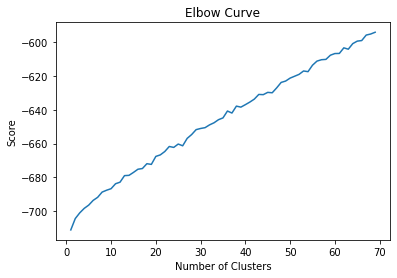

In [13]:
import matplotlib.pyplot as plt
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

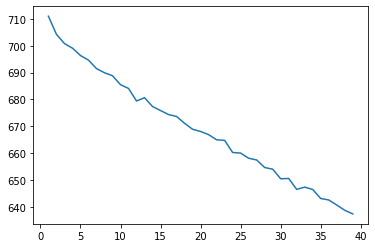

In [17]:
plt.plot(Nc_inertia, inertias)

## KMeans - Finding Optimal Number of Clusters - Silhouette Method

### Code

In [18]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , n_jobs = -1
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

In [19]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") 
    ax1.set_yticks([])  
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) 
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) 
        y_lower = y_upper + 10  
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) 
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

### Silhouette Score plots

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster

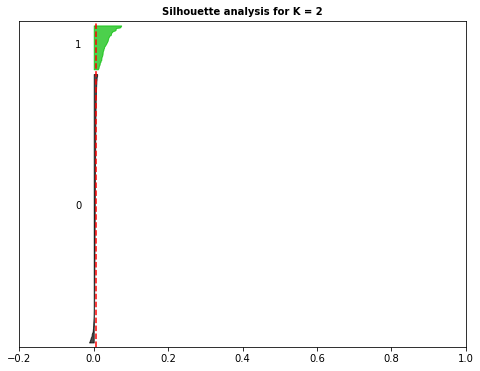

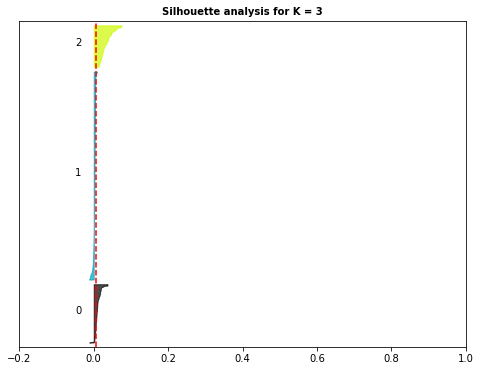

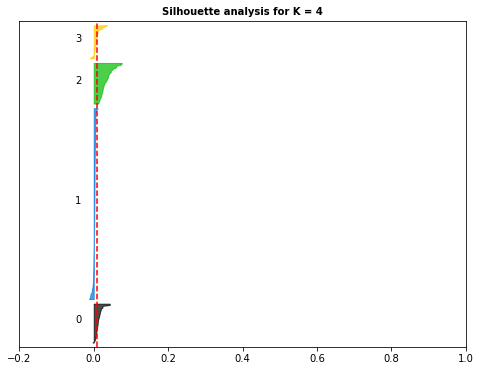

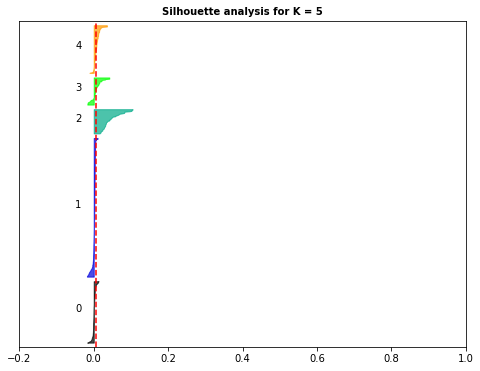

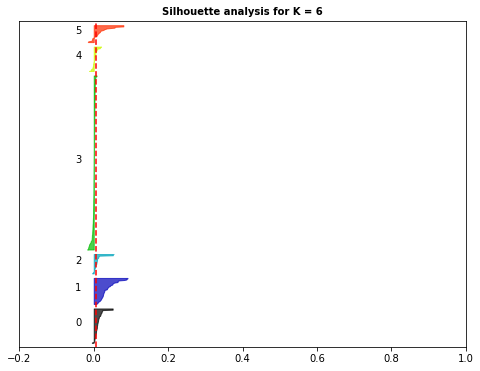

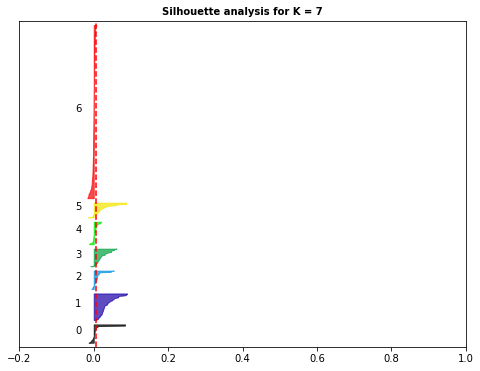

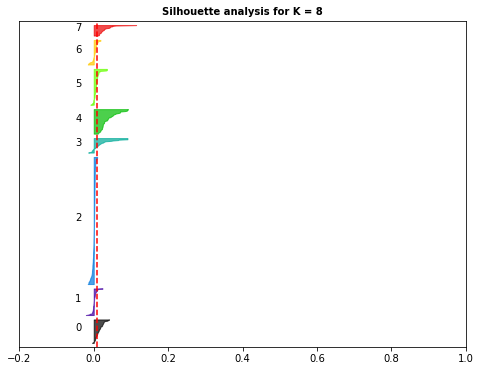

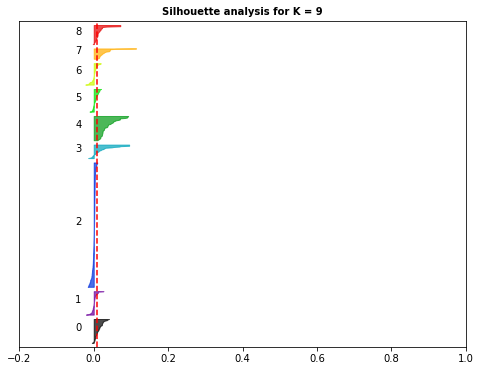

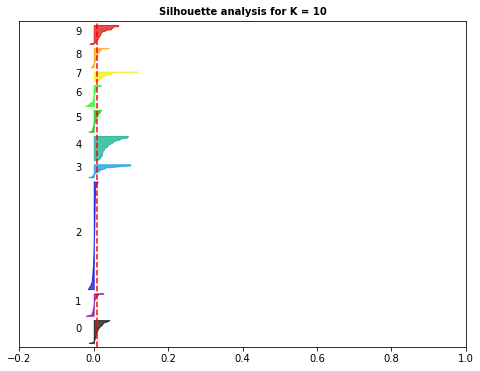

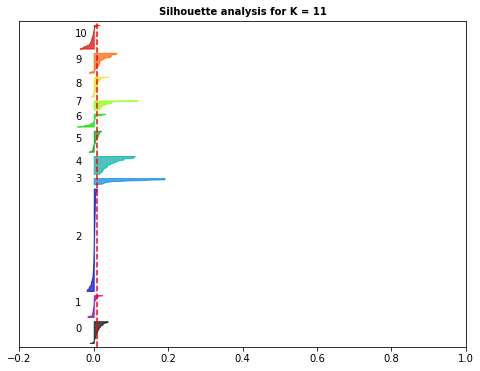

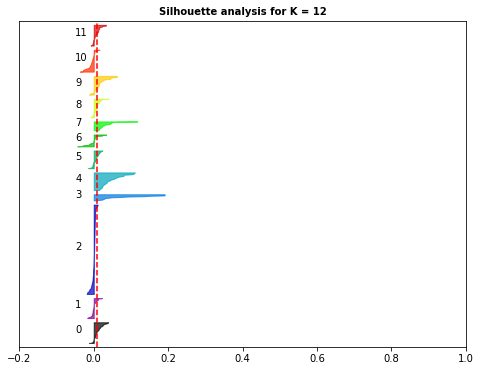

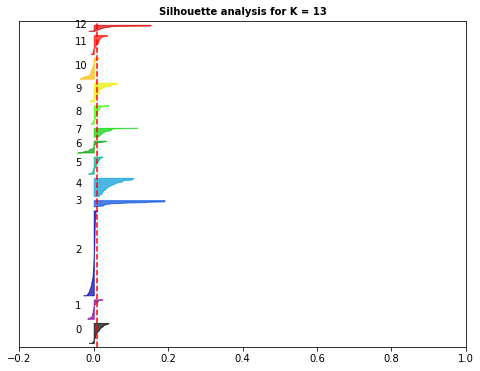

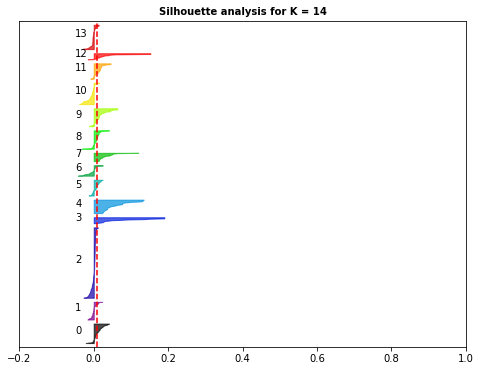

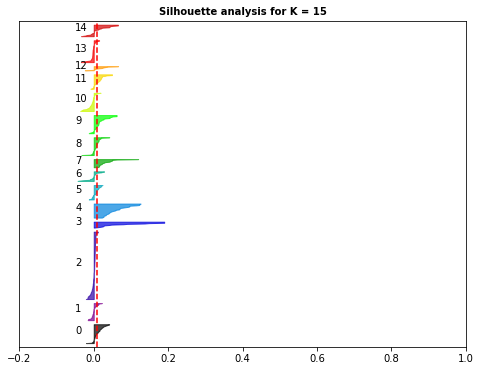

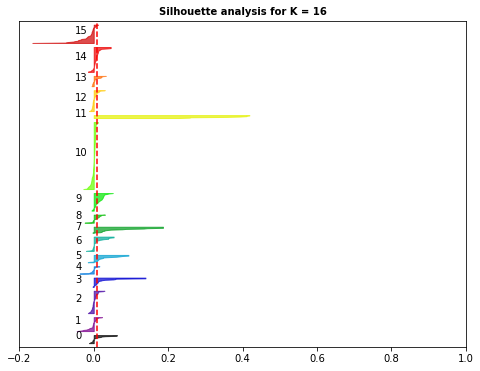

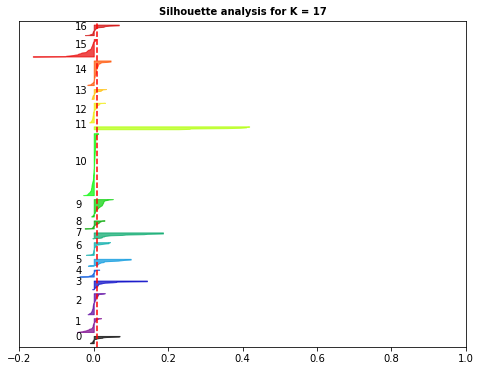

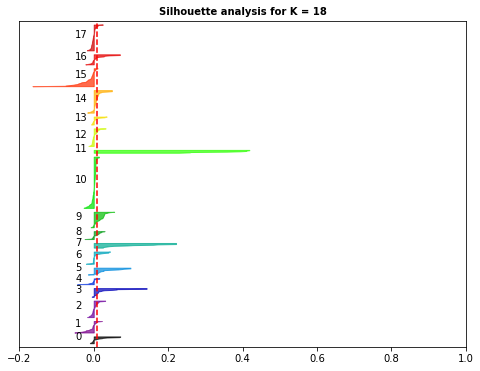

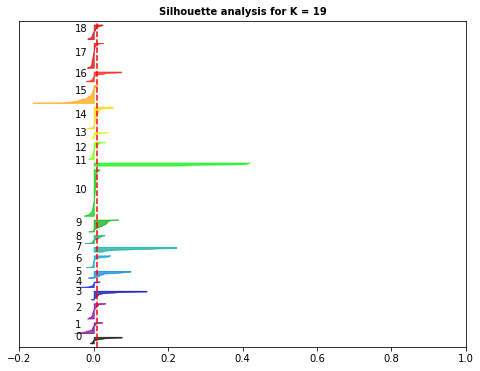

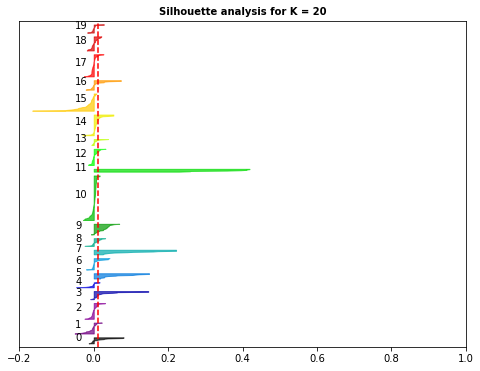

In [20]:
k = 20
kmeans_results = run_KMeans(k, final_df)
silhouette(kmeans_results, final_df, plot=True)

## Cluster Analysis

### Words by Cluster

#### Code

In [21]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

#### Visualisation

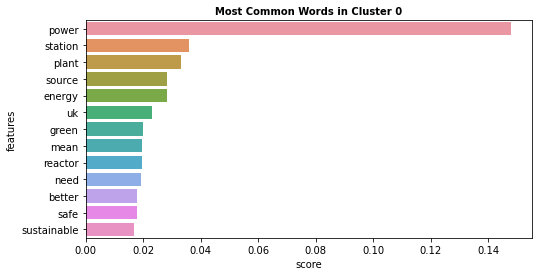

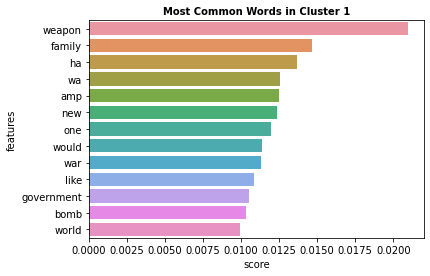

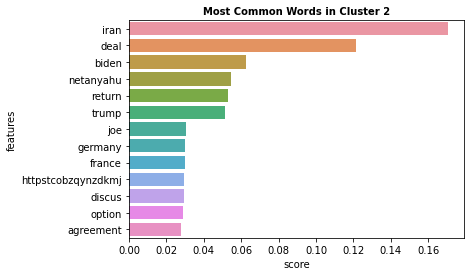

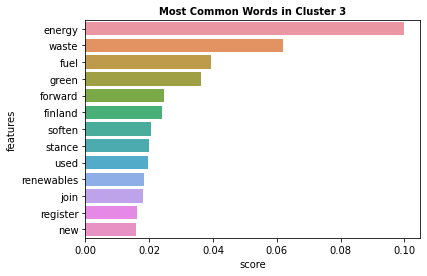

In [22]:
best_result = 4
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

### WordClouds

#### Code

In [23]:
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

#### Visualisation

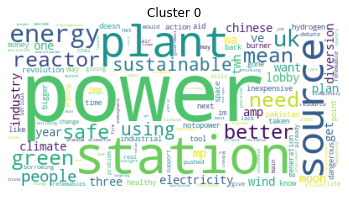

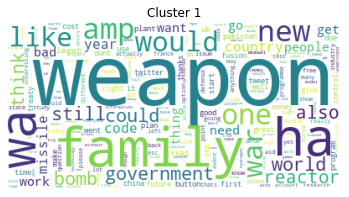

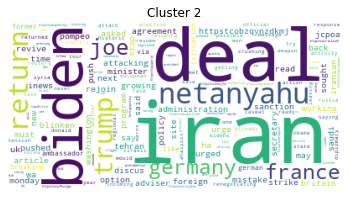

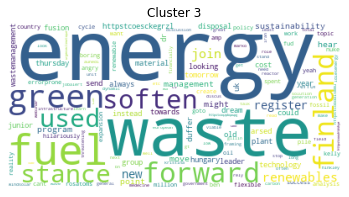

In [24]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

## Country Visualisation

In [ ]:
df['near'] = df['near'].str.replace('London', 'UK')
df['near'] = df['near'].str.replace('Paris', 'FR')

In [80]:
labels = kmeans.labels_ 
df['label'] = labels
df.head()

,cashtags,conversation_id,created_at,date,day,geo,hashtags,hour,id,language,...,translate,tweet,urls,user_id,user_id_str,user_rt,user_rt_id,username,video,label
0,[],1331664732894474240,1.606329e+12,2020-11-25 18:23:08,3,,"[karabakhisazerbaijan, dontbelievearmenia]",18,1331664732894474240,en,...,,stepan danielyan chairman center partnership d...,[],1285880933988675585,1285880933988675585,,,ElyaMK1,0,3
1,[],1331644466445361156,1.606328e+12,2020-11-25 18:20:59,3,,[],18,1331664195134349323,en,...,,waste million country space program weapon,[],337062836,337062836,,,paulmward66,0,3
2,[],1331649415476604928,1.606328e+12,2020-11-25 18:15:24,3,,[],18,1331662788855554048,en,...,,conservative strong believer family progressi...,[],1145733731493339137,1145733731493339137,,,BritishConserv3,0,1
3,[],1331644466445361156,1.606328e+12,2020-11-25 18:14:36,3,,[],18,1331662588812423168,en,...,,foreign aid mostly bribery especially given af...,[],1274964821902049280,1274964821902049280,,,MarcFre33138654,0,0
4,[],1331662471589990402,1.606328e+12,2020-11-25 18:14:08,3,,[],18,1331662471589990402,en,...,,national infrastructure strategy government te...,[],165950389,165950389,,,mattrooney11,1,3


In [79]:
import json
import geopandas as gpd

#with open("C:/Users/thomasgiannetti/Desktop/world-countries.json") as json_file:
#    json_data = json.load(json_file)
#    print(json_data)

#country_geo = json.load(open("/Users/thomasgiannetti/Desktop/world-countries.json"))
#pd.read_json(open("/Users/thomasgiannetti/Desktop/world-countries.json"))
#df.to_csv
# Loading countries polygons
#geo_path = 'world-countries.json'
#country_geo = json.load(open(r "C:\Users\thomasgiannetti\Desktop\world-countries.json"))
#gpf = gpd.read_file()

In [57]:
!pwd

/Users/thomasgiannetti/code/contatc2/green_mood_tracker/green_mood_tracker
